In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from inceptionresnet import inceptionresnetv2

In [5]:
from object_detection_utils.object_detection_helper import *
from object_detection_utils.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_utils.RetinaNet import RetinaNet
from object_detection_utils.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

ModuleNotFoundError: No module named 'BoundingBox'

In [3]:
import fastai.utils.collect_env
fastai.utils.collect_env.check_perf()

Running performance checks.

*** libjpeg-turbo status
❓ libjpeg-turbo's status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version 5.3.0.post1

*** Pillow-SIMD status
✔ Running Pillow-SIMD 5.3.0.post1

*** CUDA status
✔ Running the latest CUDA 9.0.176 with NVIDIA driver 396.54

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


In [4]:
torch.cuda.empty_cache()

### Check dataset 

In [5]:
path = Path('data/ILSVRC/Data/CLS-LOC')

In [6]:
os.listdir(path)

['export',
 'imagenet_199px_object_detection.pkl',
 'imagenet_299px_object_detection.pkl',
 'models',
 'test',
 'train',
 'valid']

In [7]:
len(os.listdir(path/'train'))

1000

In [8]:
os.listdir(path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [9]:
len(os.listdir(path/'valid'))

50000

In [10]:
os.listdir(path/'valid')[:5]

['ILSVRC2012_val_00000007.JPEG',
 'ILSVRC2012_val_00000008.JPEG',
 'ILSVRC2012_val_00000009.JPEG',
 'ILSVRC2012_val_00000010.JPEG',
 'ILSVRC2012_val_00000011.JPEG']

In [11]:
len(os.listdir(path/'test'))

100000

In [12]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00026354.JPEG',
 'ILSVRC2012_test_00000007.JPEG',
 'ILSVRC2012_test_00000008.JPEG',
 'ILSVRC2012_test_00000009.JPEG',
 'ILSVRC2012_test_00000010.JPEG']

In [13]:
annotation_path = Path('data/ILSVRC/Annotations/CLS-LOC')

In [14]:
os.listdir(annotation_path)[:5]

['train', 'valid']

In [15]:
len(os.listdir(annotation_path/'train'))

1000

In [16]:
os.listdir(annotation_path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [17]:
os.listdir(annotation_path/'train/n01440764')[:5]

['n01440764_4167.xml',
 'n01440764_10548.xml',
 'n01440764_10569.xml',
 'n01440764_10587.xml',
 'n01440764_10592.xml']

In [18]:
len(os.listdir(annotation_path/'valid'))

50000

In [19]:
os.listdir(annotation_path/'valid')[:5]

['ILSVRC2012_val_00000006.xml',
 'ILSVRC2012_val_00000007.xml',
 'ILSVRC2012_val_00000008.xml',
 'ILSVRC2012_val_00000009.xml',
 'ILSVRC2012_val_00000010.xml']

In [20]:
os.listdir(annotation_path/'valid')[0]

'ILSVRC2012_val_00000006.xml'

### extract annotations

In [21]:
#path

In [22]:
#import xml.etree.ElementTree as ET

In [23]:
#fnames = []
#lbl_bboxes = []

In [24]:
#for annotation in os.listdir('data/ILSVRC/Annotations/CLS-LOC/valid/'):
#    bboxes = []
#    root = ET.parse('data/ILSVRC/Annotations/CLS-LOC/valid/'+annotation).getroot()
#    
#    bbox_tag = root.findall('object/bndbox')
#    xmin = [r.find('xmin').text for r in bbox_tag]
#    ymin = [r.find('ymin').text for r in bbox_tag]
#    xmax = [r.find('xmax').text for r in bbox_tag]
#    ymax = [r.find('ymax').text for r in bbox_tag]
#    
#    for i in range(0, len(bbox_tag)):
#        bboxes.append([int(ymin[i]), int(xmin[i]), int(ymax[i]), int(xmax[i])])
#    
#    obj_tag = root.findall('object')
#    category = [r.find('name').text for r in obj_tag]
#    
#    fname_tag = root.findall('filename')
#    fname = fname_tag[0].text + '.JPEG' 
#    fnames += ['valid' + '/' + fname]
#    
#    lbl_bboxes.append([bboxes, category])

In [25]:
#for folder in os.listdir('data/ILSVRC/Annotations/CLS-LOC/train/'):
#    for annotation in os.listdir('data/ILSVRC/Annotations/CLS-LOC/train/' + folder):
#        bboxes = []
#        root = ET.parse('data/ILSVRC/Annotations/CLS-LOC/train/' + folder + '/' + annotation).getroot()
#
#        bbox_tag = root.findall('object/bndbox')
#        xmin = [r.find('xmin').text for r in bbox_tag]
#        ymin = [r.find('ymin').text for r in bbox_tag]
#        xmax = [r.find('xmax').text for r in bbox_tag]
#        ymax = [r.find('ymax').text for r in bbox_tag]
#
#        for i in range(0, len(bbox_tag)):
#            bboxes.append([int(ymin[i]), int(xmin[i]), int(ymax[i]), int(xmax[i])])
#
#        obj_tag = root.findall('object')
#        category = [r.find('name').text for r in obj_tag]
#
#        fname_tag = root.findall('filename')
#        fname = fname_tag[0].text + '.JPEG' 
#        fnames += ['train/' + folder + '/' + fname]
#        
#        lbl_bboxes.append([bboxes, category])

In [26]:
#fname2bbox = dict(zip(fnames, lbl_bboxes))

In [27]:
#dict(list(fname2bbox.items())[0:4])

In [28]:
#len(fname2bbox)

### define metric 

In [29]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

### for the full ILSV2017 classification dataset

In [30]:
def path2fn(path):
    if 'val' in path:
        return re.search('\w*\/\w*\.JPEG$', path).group(0)
    else:
        return re.search('\w*\/\w*\/\w*\.JPEG$', path).group(0)

In [31]:
#get_y_func = lambda o: fname2bbox[path2fn(o)]

In [32]:
#SZ = 199

In [33]:
#list(fname2bbox.keys())[0]

In [34]:
#data_bunch = (ObjectItemList.from_df(pd.DataFrame(data=list(fname2bbox.keys())), path=path)
#                            .split_by_rand_pct(valid_pct=0.2, seed=21)
#                            .label_from_func(get_y_func, label_cls=ObjectCategoryList)
#                            .transform(get_transforms(), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
#                            .databunch(bs=46, num_workers=8, collate_fn=bb_pad_collate)
#                            .normalize(imagenet_stats))

In [35]:
#data_bunch.save('imagenet_199px_object_detection.pkl')

In [36]:
#SZ = 299

In [37]:
#data_bunch = (ObjectItemList.from_df(pd.DataFrame(data=list(fname2bbox.keys())), path=path)
#                            .split_by_rand_pct(valid_pct=0.2, seed=21)
#                            .label_from_func(get_y_func, label_cls=ObjectCategoryList)
#                            .transform(get_transforms(), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
#                            .databunch(bs=16, num_workers=8, collate_fn=bb_pad_collate)
#                            .normalize(imagenet_stats))

In [38]:
#data_bunch.save('imagenet_299px_object_detection.pkl')

### if the databunch has been saved

In [39]:
data_bunch = load_data('data/ILSVRC/Data/CLS-LOC', 'imagenet_199px_object_detection.pkl', 
                       collate_fn=bb_pad_collate, bs=16, num_workers=8)

### quick look at the images

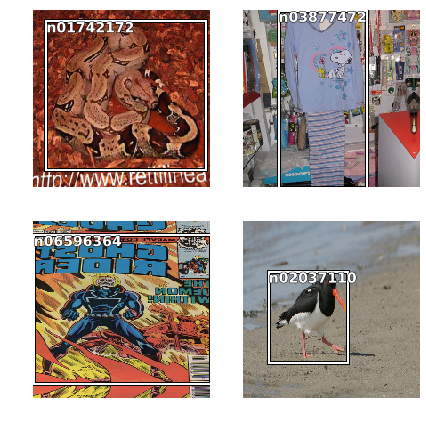

In [40]:
data_bunch.show_batch(rows=2, figsize=(6,6))

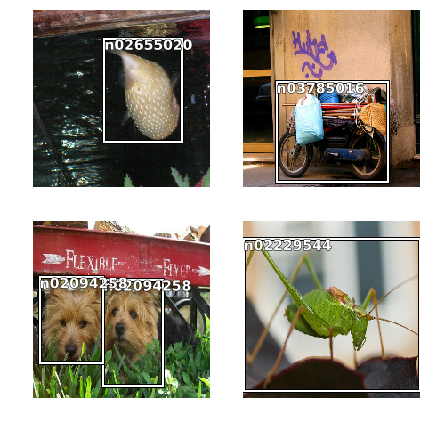

In [41]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

In [42]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [43]:
#fig,ax = plt.subplots(figsize=(15,15))
#ax.imshow(image2np(data_bunch.valid_ds[0][0].data))
#
#for i, bbox in enumerate(anchors[:18]):
#    bb = bbox.numpy()
#    x = (bb[0] + 1) * 199 / 2 
#    y = (bb[1] + 1) * 199 / 2 
#    w = bb[2] * 199 / 2
#    h = bb[3] * 199 / 2
#    
#    rect = [x,y,w,h]
#    draw_rect(ax,rect)

In [44]:
#all_boxes, all_labels = show_anchors_on_images(data_bunch, anchors, figsize=(25,25))

### create learner with inceptionresnetv2 (the pytorch model is already pretrained on imagenet)

In [45]:
def inception(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = inceptionresnetv2(pretrained=pretrained)
    return nn.Sequential(*model.children())

In [46]:
n_classes = data_bunch.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(inception, True, -2)
model = RetinaNet(encoder, n_classes=data_bunch.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)

In [47]:
#voc = PascalVOCMetric(anchors, 199, [i for i in data_bunch.train_ds.y.classes[1:]])
learn = Learner(data_bunch, model, loss_func=crit, callback_fns=[ShowGraph], metrics=[])

In [48]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [49]:
#learn = cnn_learner(data_bunch, inception, pretrained=True,
#                   cut=-2, split_on=lambda m: (m[0][9], m[1]))

In [50]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (4): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU()
   (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU()
   (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (11): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (12): ReLU()
   (13): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (14): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (15): ReLU()
 ), Sequential(


In [51]:
learn.freeze()

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: The size of tensor a (4) must match the size of tensor b (8) at non-singleton dimension 3

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(lr), div_factor=15)

In [ ]:
learn.save('199px_object_detection_inceptionresnetv2_frozen');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 2e-5

In [ ]:
lrs = learn.lr_range(slice(lr/9,lr))
lrs

In [ ]:
learn.fit_one_cycle(3, max_lr=lrs, div_factor=35)

In [ ]:
learn.save('199px_object_detection_inceptionresnetv2');

### scale up image size to 299

In [15]:
data_bunch = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=299, num_workers=8, bs=16) \
                           .normalize(imagenet_stats)

In [16]:
learn = cnn_learner(data_bunch, inceptionresnetv2, pretrained=True,
                   cut=-2, split_on=lambda m: (m[0][9], m[1]))

In [17]:
learn.metrics=[top_5_accuracy, accuracy]

In [18]:
learn.load('199px_inceptionresnetv2');

In [26]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


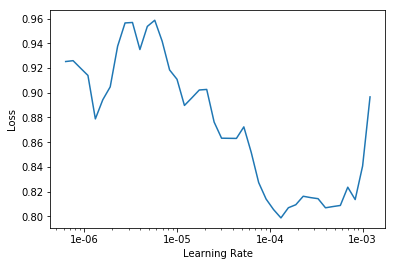

In [29]:
learn.recorder.plot()

In [27]:
lr = 1e-4

In [28]:
lrs = learn.lr_range(slice(lr/27,lr))

In [29]:
lrs

array([3.703704e-06, 1.924501e-05, 1.000000e-04])

In [30]:
learn.fit_one_cycle(2, max_lr=lrs, div_factor=35)

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,0.611931,1.233685,0.938100,0.778920,11:17:30
1,0.475397,1.210095,0.942600,0.793460,11:19:38


In [31]:
#learn.save('299px_inceptionresnetv2')

In [18]:
learn.load('299px_inceptionresnetv2');

In [27]:
interpr = learn.interpret()

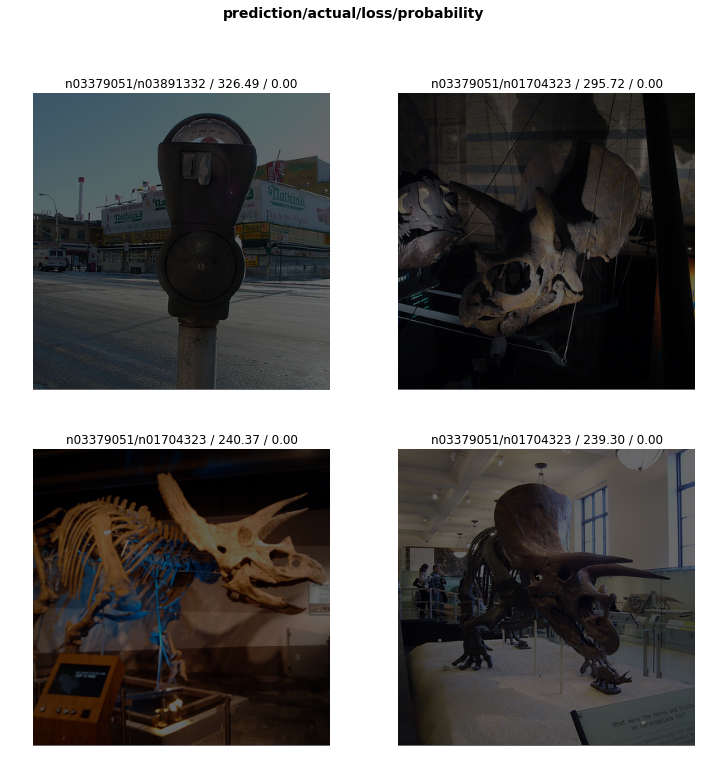

In [30]:
interpr.plot_top_losses(4, figsize=(12,12))

In [19]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


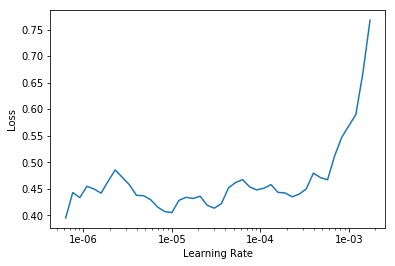

In [29]:
learn.recorder.plot()

In [20]:
lr = 1e-5

In [ ]:
lrs = learn.lr_range(slice(lr/9,lr))
lrs

In [ ]:
learn.fit_one_cycle(2, max_lr=lrs, div_factor=35)

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,0.497514,1.556440,0.935820,0.785760,10:52:04


In [ ]:
learn.save('299px_inceptionresnetv2_continued')

## prediction 

In [34]:
path

PosixPath('data/ILSVRC/Data/CLS-LOC')

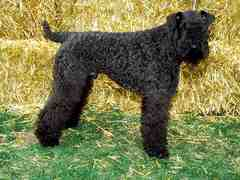

In [38]:
img = open_image(path/'train/n02093859/n02093859_1049.JPEG')
img

In [39]:
cl, label, prob = learn.predict(img)

In [59]:
cl, label #, prob

(Category n02093859, tensor(183))

In [41]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

In [54]:
{k: key_to_classname[k] for k in list(key_to_classname)[:5]}

{'?????????': 'dummy class for index 0',
 'n02119789': 'kit fox, Vulpes macrotis',
 'n02100735': 'English setter',
 'n02110185': 'Siberian husky',
 'n02096294': 'Australian terrier'}

In [55]:
key_to_classname[str(cl)]

'Kerry blue terrier'

In [8]:
learn.export('export/export.pkl')

In [9]:
learn = load_learner('export')